In [1]:
from fastai.vision.all import *

In [2]:
path = Path('/kaggle/input/intel-image-classification')
path.ls()

(#3) [Path('/kaggle/input/intel-image-classification/seg_train'),Path('/kaggle/input/intel-image-classification/seg_pred'),Path('/kaggle/input/intel-image-classification/seg_test')]

In [3]:
(path/'seg_train').ls(), (path/'seg_pred').ls()

((#1) [Path('/kaggle/input/intel-image-classification/seg_train/seg_train')],
 (#1) [Path('/kaggle/input/intel-image-classification/seg_pred/seg_pred')])

In [4]:
(path/'seg_train'/'seg_train').ls()

(#6) [Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/street'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/buildings'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/sea'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/forest'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/glacier')]

In [5]:
im_files = get_image_files(path)
im_files

(#24335) [Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg'),Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg')...]

<Axes: >

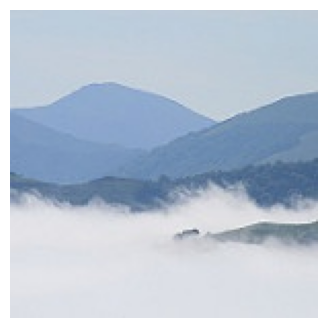

In [6]:
im = Image.open(im_files[0])
show_image(im)

In [7]:
im.shape

(150, 150)

In [8]:
splitter=GrandparentSplitter(train_name='seg_train/seg_train', valid_name='seg_pred/seg_pred')

In [9]:
def get_dls(bs=64):
    dblocks = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2),
        get_y=parent_label,
        item_tfms=Resize(64),
        batch_tfms=Normalize()
    )

    return dblocks.dataloaders(path, bs=bs)

dls = get_dls()
        

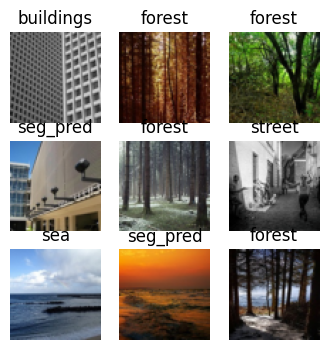

In [10]:
dls.show_batch(max_n = 9, figsize=(4,4))

In [11]:
len(dls.train.items), len(dls.valid.items)

(19468, 4867)

In [12]:
dls.c

7

In [13]:
def conv(ni, nf, ks=3, act=True):
    layer = [nn.Conv2d(ni, nf, padding=ks//2, kernel_size=ks, stride=2)]
    layer.append(nn.BatchNorm2d(nf))
    if act:
        layer.append(nn.ReLU())
    
    return nn.Sequential(*layer) 

In [14]:
from fastai.callback.hook import *
def get_learner(model_func, epoch=1, lr=0.03):
    learner = Learner(dls, 
                      model_func(), 
                      loss_func=CrossEntropyLossFlat(),
                      metrics=accuracy,
                      cbs=ActivationStats(with_hist=True)
                     )
    learner.fit_one_cycle(epoch, lr)
    
    return learner

## conv-128 layers, epoch=20, bs=64

In [16]:
def model_128():
    return sequential(
        conv(3, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 128),
        conv(128, dls.c, act=False),
        Flatten()
    )
dls = get_dls(64)
learn = get_learner(model_func=model_128, epoch=20)

epoch,train_loss,valid_loss,accuracy,time
0,1.390309,1.404836,0.427368,00:52
1,1.248505,1.255068,0.440518,00:39
2,1.183375,1.163211,0.490857,00:39
3,1.134664,1.260728,0.454900,00:37
4,1.101592,1.259614,0.459010,00:36
5,1.053262,1.163043,0.499486,00:35
6,1.024348,1.088838,0.519211,00:35
7,0.983464,1.026278,0.540374,00:35
8,0.941609,1.050365,0.539963,00:42
9,0.888110,1.079801,0.527224,00:35


In [21]:
learn.activation_stats.color_dim(-1)

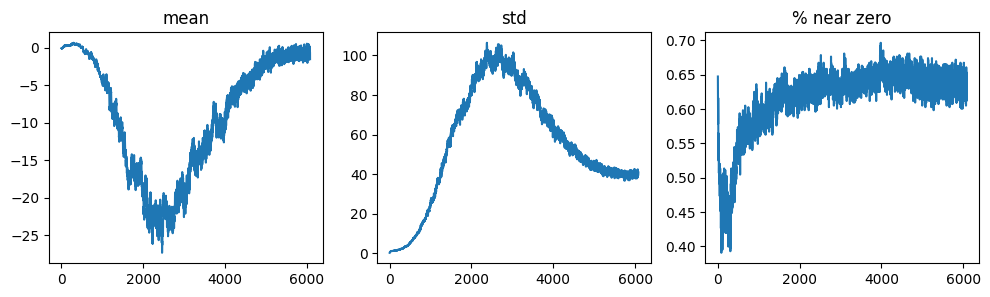

In [18]:
learn.activation_stats.plot_layer_stats(-2)

## conv-128 layers, epoch=10, bs=256

In [26]:
dls = get_dls(256)
learn = get_learner(model_func=model_128, epoch=10)

epoch,train_loss,valid_loss,accuracy,time
0,1.494736,1.478561,0.395315,00:38
1,1.301568,1.360707,0.435176,00:34
2,1.174703,1.181386,0.470516,00:35
3,1.092339,1.128713,0.502568,00:35
4,1.039592,1.232791,0.485926,00:34
5,0.987787,1.100380,0.515513,00:36
6,0.911424,1.136213,0.495993,00:35
7,0.810365,1.100930,0.523320,00:35
8,0.676987,1.173952,0.511198,00:35
9,0.583924,1.198342,0.511198,00:35


Its overfitting a bit!!!

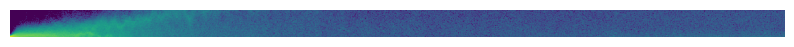

In [24]:
learn.activation_stats.color_dim(-2)

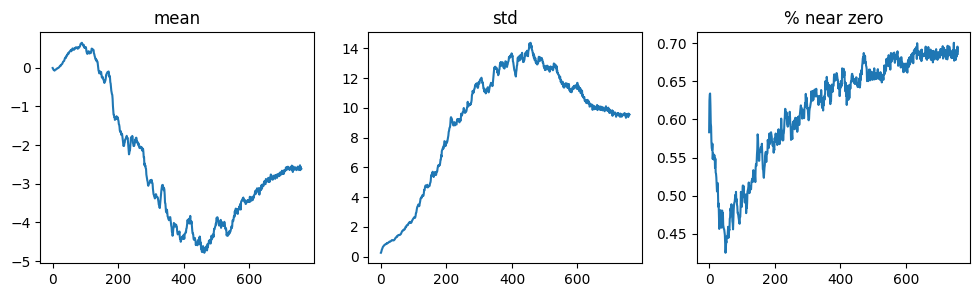

In [27]:
learn.activation_stats.plot_layer_stats(-2)

More activations are near `0`.

## conv-128 layers, epoch=8, bs=512

In [29]:
dls = get_dls(512)
learn = get_learner(model_func=model_128, epoch=8)

epoch,train_loss,valid_loss,accuracy,time
0,1.590447,2.033697,0.376413,00:45
1,1.384587,1.801096,0.357510,00:41
2,1.251194,1.335519,0.448531,01:05
3,1.157445,1.209822,0.464146,00:47
4,1.079627,1.096289,0.512431,00:45
5,1.002411,1.086959,0.531744,00:39
6,0.914051,1.108836,0.518184,00:38
7,0.828322,1.099608,0.518389,00:40


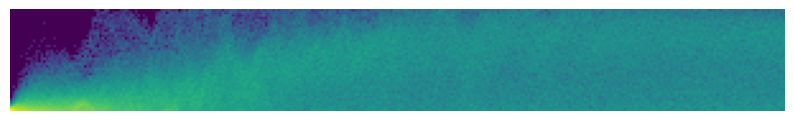

In [30]:
learn.activation_stats.color_dim(-2)

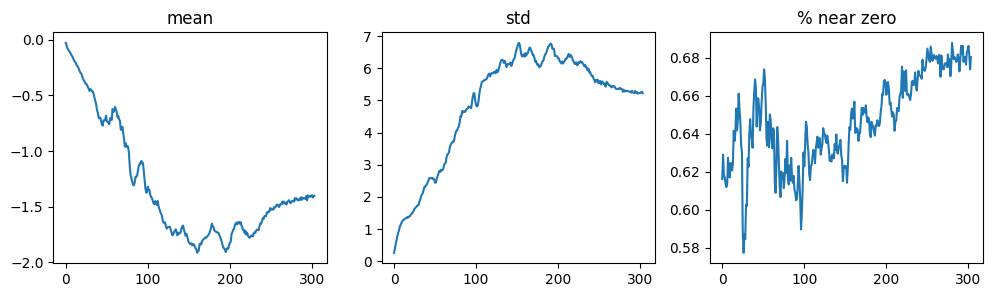

In [31]:
learn.activation_stats.plot_layer_stats(-2)

## conv-256 layers, epoch=20, bs=64 with few linear layers with a down sample conv layer of 128

In [36]:
def model_256():
    return sequential(
        conv(3, 8, ks=5),   # 32 * 32
        conv(8, 16),        # 16 * 16
        conv(16, 32),       # 8 * 8
        conv(32, 64),       # 4 * 4
        conv(64, 128),      # 2 * 2
        conv(128, 256),     # 1 * 1
        conv(256, 128, act=False),   # down sample     
        Flatten(),

        nn.Linear(128, 32),
        nn.Linear(32, dls.c),
        Flatten()
    )
dls = get_dls(64)
learn = get_learner(model_func=model_256, epoch=20)

epoch,train_loss,valid_loss,accuracy,time
0,1.308222,1.333169,0.406205,00:43
1,1.264819,1.370450,0.470516,00:43
2,1.215493,1.281804,0.400657,00:44
3,1.189360,1.225992,0.491884,00:43
4,1.164186,1.217189,0.441751,00:48
5,1.101856,1.381866,0.456750,00:45
6,1.051272,1.175667,0.475447,00:42
7,1.031281,1.182823,0.513869,00:41
8,0.981592,1.115216,0.513047,00:41
9,0.912883,1.238184,0.487364,00:41


In [37]:
learn.activation_stats.color_dim(-5)

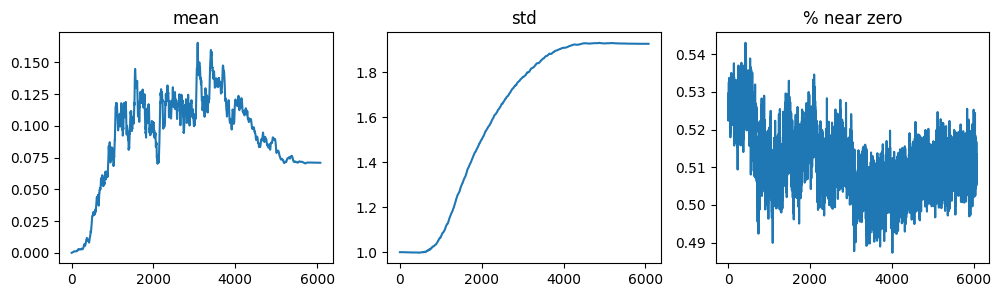

In [38]:
learn.activation_stats.plot_layer_stats(-5)

## conv-256 layers, epoch=10, bs=512 with few linear layers with a down sample conv layer of 128

In [40]:
dls = get_dls(bs=512)
learn = get_learner(model_func=model_256, epoch=10)

epoch,train_loss,valid_loss,accuracy,time
0,1.452699,2.469531,0.330594,00:40
1,1.336502,1.448988,0.404972,00:41
2,1.253723,1.286038,0.398397,00:38
3,1.175926,1.321934,0.455722,00:39
4,1.106082,1.315755,0.454078,00:38
5,1.045787,1.284615,0.476063,00:37
6,0.970802,1.120205,0.505856,00:37
7,0.880534,1.147907,0.499075,00:37
8,0.771227,1.243303,0.519211,00:37
9,0.670399,1.265064,0.516129,00:37


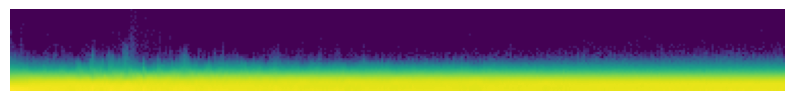

In [41]:
learn.activation_stats.color_dim(-5)

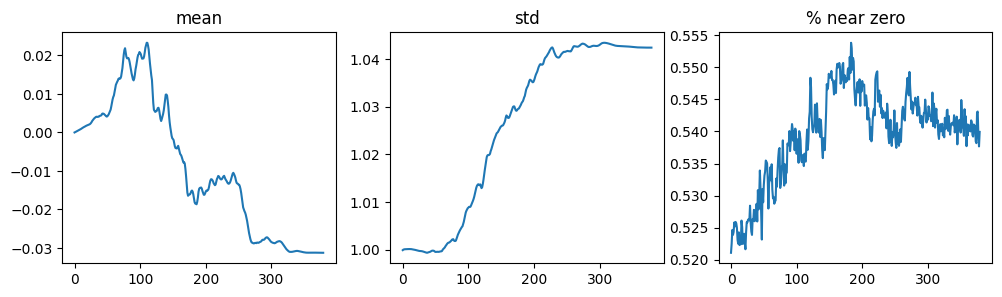

In [42]:
learn.activation_stats.plot_layer_stats(-5)

## conv-256 layers, epoch=20, bs=64 with few linear layers without a down sample conv layer 

In [44]:
def model_256_d():
    return sequential(
        conv(3, 8, ks=5),   # 32 * 32
        conv(8, 16),        # 16 * 16
        conv(16, 32),       # 8 * 8
        conv(32, 64),       # 4 * 4
        conv(64, 128),      # 2 * 2
        conv(128, 256),     # 1 * 1
        Flatten(),
        nn.Linear(256, 32),
        nn.Linear(32, dls.c),
        Flatten()
    )
dls = get_dls(64)
learn = get_learner(model_func=model_256_d, epoch=20)

epoch,train_loss,valid_loss,accuracy,time
0,1.273050,1.294001,0.457571,00:42
1,1.258029,1.327937,0.452229,00:40
2,1.230663,1.320193,0.451613,00:41
3,1.179806,1.307395,0.430861,00:41
4,1.142236,1.127923,0.505239,00:45
5,1.111953,1.100725,0.474214,00:43
6,1.063139,1.241874,0.483871,00:48
7,1.014833,1.199404,0.478940,00:39
8,0.971609,1.078985,0.508321,00:41
9,0.943343,1.137361,0.512636,00:43


In [46]:
learn.activation_stats.color_dim(5)

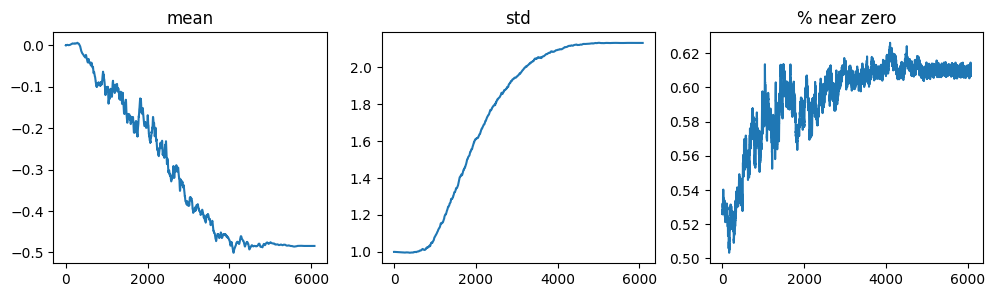

In [47]:
learn.activation_stats.plot_layer_stats(5)

## conv-256 layers, epoch=5, bs=512 with few linear layers without a down sample conv layer 

In [48]:
dls = get_dls(512)
learn = get_learner(model_func=model_256_d, epoch=5)

epoch,train_loss,valid_loss,accuracy,time
0,1.377935,3.611176,0.314773,00:39
1,1.285946,1.248787,0.453257,00:36
2,1.186244,1.148083,0.494144,00:37
3,1.101351,1.097539,0.517773,00:39
4,1.021138,1.046897,0.528662,00:38


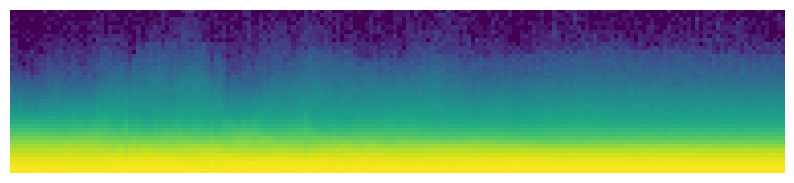

In [49]:
learn.activation_stats.color_dim(5)

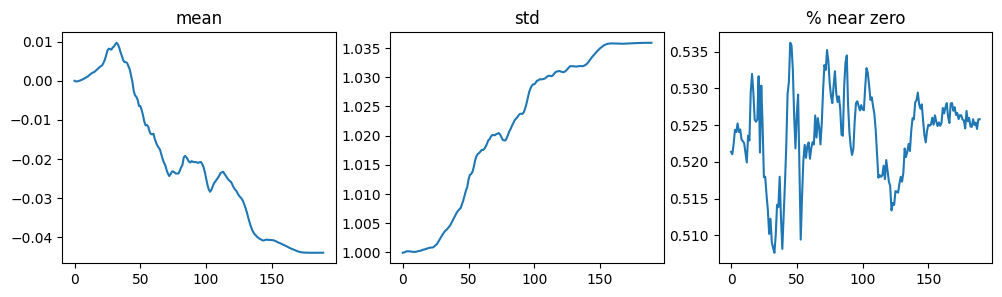

In [50]:
learn.activation_stats.plot_layer_stats(5)

<Axes: >

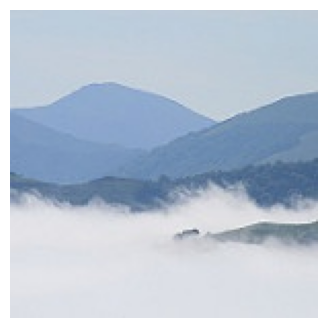

In [51]:
tst_im = Image.open(im_files[0])
show_image(tst_im, cmap='Greys')

In [52]:
prd = learn.predict(tst_im)
prd

('glacier',
 tensor(2),
 tensor([2.3915e-04, 4.9295e-04, 3.8992e-01, 7.2565e-02, 1.6340e-01, 3.7265e-01,
         7.2756e-04]))

In [59]:
im_files[0]

Path('/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg')

In [60]:
prd[2].sum()

tensor(1.0000)

Wrong prediction.
## Conclusion
1. **image size**: as image size increases here we are considering 64*64, the basic convolution does not work properly. accuracy is around `50%`. 
2. **deeper layer**: deeper layer with more layers leads to over fitting problem
3. **vanishing gradient**: the activation in the middle is near zero, propagation of zeros
4. **batch size**: if we increase the batch size no of epoch show be bit lower to minimize overfitting

Using off arch like **resnet** might solve the issues